In [1]:
import pandas as pd
from utils import Options
import pickle as pkl
import numpy as np
from glob import glob
from readresults.readres_mvpa import merge_results, parse_roi_info, exclude_participants, \
    get_subj_avg, fill_in_nvoxels, quick_get_results, group_results
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
import seaborn as sns
import matplotlib.pyplot as plt
from plotting.plot import plot_by_nvoxels, get_tfce_stats
import pingouin as pg
import os
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/home/predatt/giaald/nipype/nipype/utils/misc.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterator
/home/predatt/giaald/nipype/nipype/interfaces/base/traits_extension.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.

240415-09:02:48,846 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.0-dev+g804adc0


/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
results = merge_results(['/project/3018040.05/MVPA_results/results_main_nothresh_1718_m29.csv'])
results = exclude_participants(results)
results = parse_roi_info(results)
grouped_res = group_results(results, avg_across=['split', 'view', 'runno', 'trainmodel', 'testmodel',
                                                 'traintask', 'testtask'])

In [3]:
!ls /project/3018040.05/MVPA_results/*.csv

/project/3018040.05/MVPA_results/dummytraintest.csv
/project/3018040.05/MVPA_results/dummytraintest2.csv
/project/3018040.05/MVPA_results/mainanalysis.csv
/project/3018040.05/MVPA_results/results_main_nothresh.csv
/project/3018040.05/MVPA_results/results_main_nothresh_1718_m15.csv
/project/3018040.05/MVPA_results/results_main_nothresh_1718_m24.csv
/project/3018040.05/MVPA_results/results_main_nothresh_1718_m29.csv
/project/3018040.05/MVPA_results/results_main_nothresh_1937_m15.csv
/project/3018040.05/MVPA_results/results_wholerois.csv
/project/3018040.05/MVPA_results/splits_allsubjs.csv
/project/3018040.05/MVPA_results/trynewapproach.csv
/project/3018040.05/MVPA_results/trynewapproach_CV.csv
/project/3018040.05/MVPA_results/trysplits.csv


In [4]:
bothROIs_avg = grouped_res[grouped_res['nvoxels']!='none'].groupby(['roi', 'expected', 'subject']).mean().reset_index()

In [5]:
aov = pg.rm_anova(data=bothROIs_avg, dv='distance', within=['roi', 'expected'],
            subject='subject')
aov.round(4)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pingouin/parametric.py:693: RuntimeWarning: invalid value encountered in double_scalars
  ms_a = ss_a / df_a
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pingouin/parametric.py:695: RuntimeWarning: invalid value encountered in double_scalars
  ms_ab = ss_ab / df_ab
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pingouin/parametric.py:696: RuntimeWarning: invalid value encountered in double_scalars
  ms_as = ss_as / df_as
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pingouin/parametric.py:698: RuntimeWarning: invalid value encountered in double_scalars
  ms_abs = ss_abs / df_abs


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,roi,0.0000,0,0,NaN,NaN,NaN,NaN,NaN,1.0
1,expected,0.0516,1,33,0.0516,4.6036,0.0394,0.0394,0.1224,1.0
2,roi * expected,0.0000,0,0,NaN,NaN,NaN,NaN,NaN,1.0


In [6]:
results_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']!='none')]
#results_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']!='none')]

In [7]:
voxelavg_1718 = results_1718.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1718.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.254892,0.024042
True,0.309980,0.024040


In [8]:
pg.ttest(voxelavg_1718[voxelavg_1718['expected']==True].distance,
         voxelavg_1718[voxelavg_1718['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.14559,33,two-sided,0.039356,"[0.0, 0.11]",0.392973,1.382,0.604287


In [9]:
avg1718_left = results_1718[results_1718['hemi']=='L'].groupby(['subject', 'expected']).mean().reset_index()
avg1718_right = results_1718[results_1718['hemi']=='R'].groupby(['subject', 'expected']).mean().reset_index()

In [10]:
avg1718_left.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.296094,0.028960
True,0.334747,0.027185


In [11]:
pg.ttest(avg1718_left[avg1718_left['expected']==True].distance,
         avg1718_left[avg1718_left['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.23822,33,two-sided,0.224371,"[-0.02, 0.1]",0.236017,0.37,0.266914


In [12]:
avg1718_right.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.213690,0.023988
True,0.285213,0.024651


In [13]:
pg.ttest(avg1718_right[avg1718_right['expected']==True].distance,
         avg1718_right[avg1718_right['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.474615,33,two-sided,0.01865,"[0.01, 0.13]",0.504316,2.553,0.814377


stat_fun(H1): min=1.764446 max=2.758362
Running initial clustering
Using 276 thresholds from 0.00 to 2.75 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


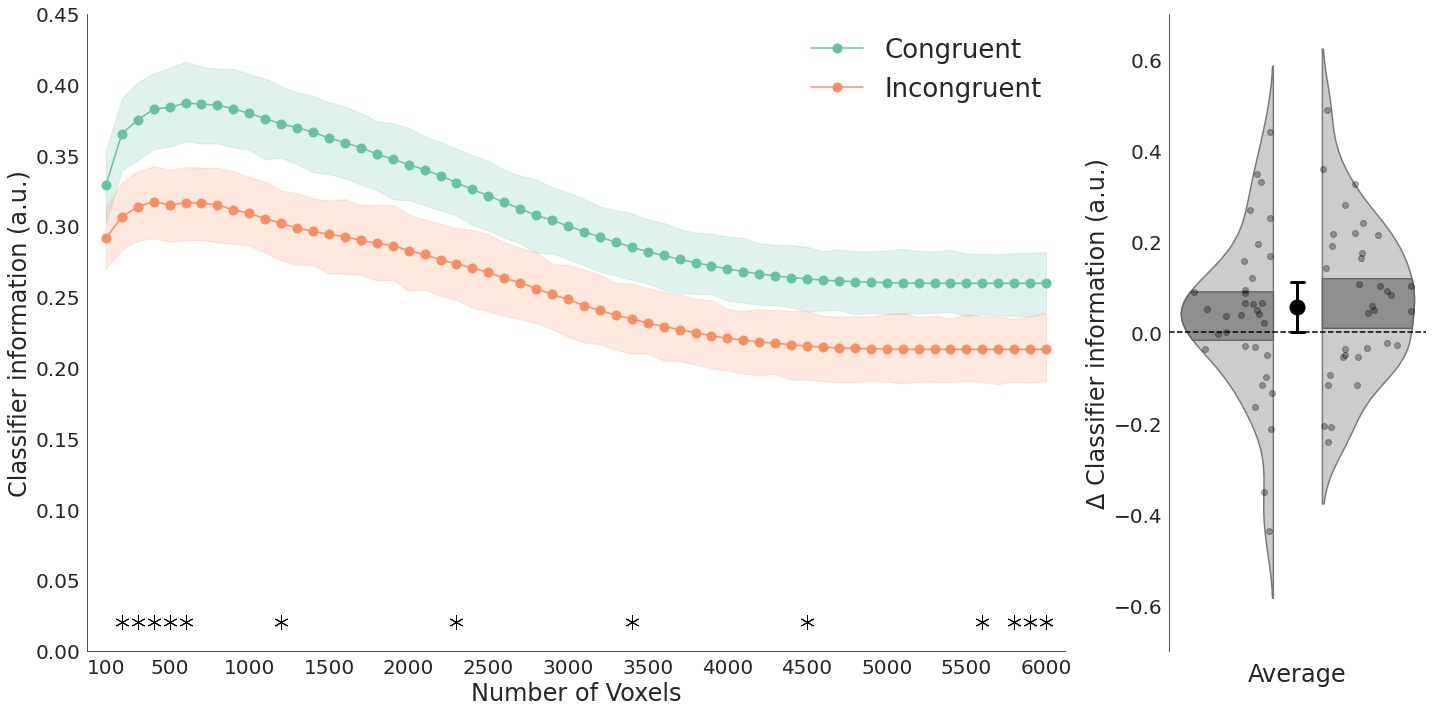

In [15]:
plot_by_nvoxels(results_1718, right_part=True)
#plt.savefig('results_plots/ba1718_nvox.pdf')

In [ ]:
voxelavg_1937 = results_1937.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1937.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.175220,0.017608
True,0.178329,0.016784


In [16]:
pg.ttest(voxelavg_1937[voxelavg_1937['expected']==True].distance,
         voxelavg_1937[voxelavg_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.218037,33,two-sided,0.828743,"[-0.03, 0.03]",0.030999,0.188,0.053538


In [17]:
avg1937_left = results_1937[results_1937['hemi']=='L'].groupby(['subject', 'expected']).mean().reset_index()
avg1937_right = results_1937[results_1937['hemi']=='R'].groupby(['subject', 'expected']).mean().reset_index()

In [18]:
avg1937_left.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.155167,0.019432
True,0.153575,0.014953


In [19]:
pg.ttest(avg1937_left[avg1937_left['expected']==True].distance,
         avg1937_left[avg1937_left['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.084802,33,two-sided,0.932931,"[-0.04, 0.04]",0.015751,0.184,0.050912


In [20]:
avg1937_right.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.195274,0.023215
True,0.203084,0.020971


In [21]:
pg.ttest(avg1937_right[avg1937_right['expected']==True].distance,
         avg1937_right[avg1937_right['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.437366,33,two-sided,0.664695,"[-0.03, 0.04]",0.060553,0.201,0.063577


stat_fun(H1): min=-0.422969 max=1.816805
Running initial clustering
Using 182 thresholds from 0.00 to 1.81 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


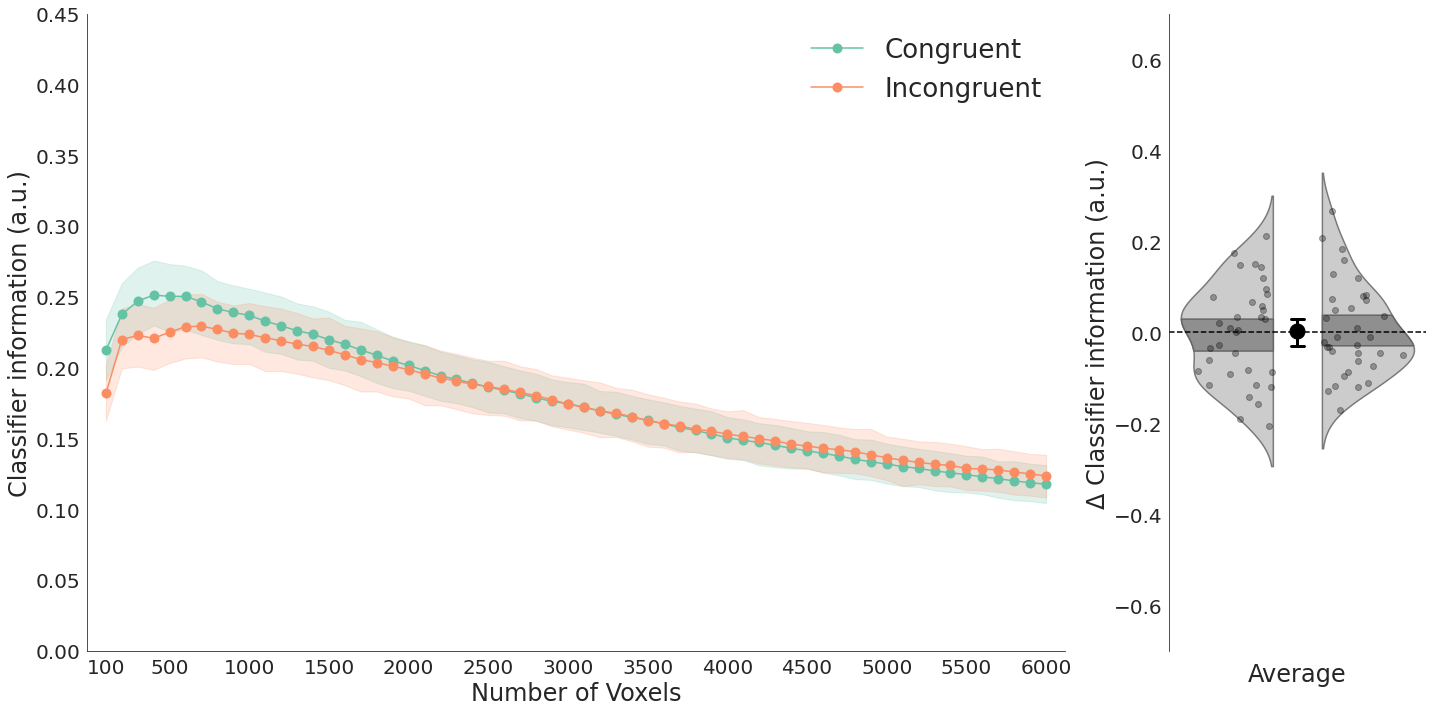

In [27]:
plot_by_nvoxels(results_1937, right_part=True)
plt.savefig('results_plots/ba1937_nvox.pdf')

In [ ]:
plot_by_nvoxels(results_1718)

In [26]:
fullroi_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1718[fullroi_1718['expected']==True].distance,
         fullroi_1718[fullroi_1718['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.111196,33,two-sided,0.042415,"[0.0, 0.1]",0.434467,1.301,0.69116


In [27]:
fullroi_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1937[fullroi_1937['expected']==True].distance,
         fullroi_1937[fullroi_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.048063,33,two-sided,0.961956,"[-0.03, 0.03]",0.010184,0.184,0.050381


<AxesSubplot:xlabel='nvoxels', ylabel='distance'>

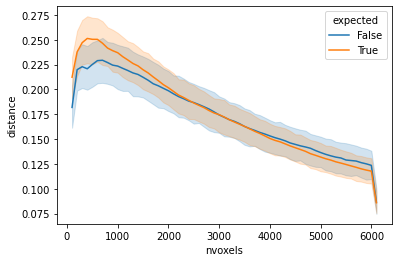

In [22]:
sns.lineplot(data=grouped_res[grouped_res['roi']=='ba-19-37'], 
             x='nvoxels', y='distance', hue='expected', ci=68)

In [ ]:
plot_by_nvoxels(results)

In [ ]:
meanres = results.groupby(['subject', 'expected']).mean().reset_index()

In [ ]:
pg.ttest(meanres[meanres['expected']==True]['distance'],
         meanres[meanres['expected']==False]['distance'], paired=True)

In [ ]:
t_obs, clusters, cluster_pv, H0 = get_tfce_stats(results, measure='distance', n_perms=1000)

In [ ]:
cluster_pv

In [ ]:
t_obs

In [ ]:
EVCdata.distance.min()

In [ ]:
LOCdata.distance.max()

In [ ]:
len(EVCdata)/34/30

In [ ]:
EVCdata.roi.nunique()

In [ ]:
plot_by_nvoxels(results)

In [ ]:
plot_by_nvoxels(EVCdata)

In [ ]:
'ba-17-18' in EVCdata.roi.unique()

In [ ]:
EVCdata.roi

In [ ]:
from plotting.plot import accs_to_diffs

avgdiffs = accs_to_diffs(EVCdata)

In [ ]:
avgdiffs = avgdiffs.groupby(['subject', 'hemi']).mean().reset_index()

In [ ]:
avgdiffs.difference.max()

In [ ]:
avgdiffs.difference.min()

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
maxvoxels = 3000
['100']+[str(x) for x in np.arange(500, maxvoxels+500, 500)]

In [ ]:
EVCdata[EVCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
LOCdata[LOCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
avgres

In [ ]:
results[results['approach']=='CV'].chunk.unique()

In [ ]:
from readresults.readres_mvpa import parse_roi_info

In [ ]:
results_avg = results.groupby(['subject', 'roi']).mean().reset_index()

In [ ]:
results = parse_roi_info(results)

In [ ]:
results = results.drop(['chunk'], axis=1)

In [ ]:
ind_vars = ['subject', 'roi', 'approach', 
            'traindataformat', 'testdataformat', 'traintask',
            'testtask', 'trainmodel', 'testmodel', 
            'hemi', 'contrast', 'nvoxels']
ind_vars = [i for i in ind_vars if i in results.columns and results[i].nunique() > 0]

In [ ]:
results_avg = results.groupby(ind_vars).mean().reset_index()

In [ ]:
results_avg = results_avg.drop(['chunk'], axis=1)

In [ ]:
results_avg.head()

In [ ]:
sns.barplot(data=results_avg, x='roi', y='distance')

In [ ]:
allinfo = 'LO_contr-objscrvsbas_top-1000'.split('_')

In [ ]:
allinfo[1] in ['L', 'R']

In [ ]:
allinfo

In [ ]:
contrindx = 1

In [ ]:
allinfo[contrindx].split('contr-')[1]

In [ ]:
a = [None, None, None]
all(v is None for v in a)

In [ ]:
sns.barplot(data=results, x='roi', y='correct')

In [ ]:
results[results['roi'].isin(['rBA17_18_L', 'rBA17_18_R',
                             'ba-17-18_L', 'ba-17-18_R'])].distance.mean()

In [ ]:
outputs = [0.3, 4.0, 6.9, 2.0, 3.5, 0.1]
targets = [4.7, 3.2, 1.0, 2.9, 3.2, 6.8]
splits = [1, 1, 1, 2, 2, 2]
example_res = pd.DataFrame(
    list(zip(outputs, targets, splits)),
    columns=['output', 'target', 'split'])

In [ ]:
example_res

In [ ]:
x = np.array([3, 4, 5])
np.isin(x, [5])

In [ ]:
example_res = np.nan
isinstance(example_res, float) and pd.isnull(example_res)

In [ ]:
pd.isna(example_res).all()

In [ ]:
outs2 = [0.5, 0.65, 1.2]
splits2 = [3, 3, 3]
example_res_2 = pd.DataFrame(
    list(zip(outs2, splits2)),
    columns=['output', 'split'])

In [ ]:
all_res = pd.concat([example_res, example_res_2])

In [ ]:
all_res

In [ ]:
for s in sorted(example_res.split.unique()):
    thissplitlength = len(example_res[example_res['split']==s])
    example_res.loc[example_res['split']==s, 'sample'] = list(range(thissplitlength))

In [ ]:
groupedres = example_res.groupby('sample').mean().reset_index().drop(['sample', 'split'], axis=1)

In [ ]:
groupedres

In [ ]:
agg_functions = {'output': 'mean', 'target': 'sum'}

#create new DataFrame by combining rows with same id values
res_new = example_res.groupby(example_res['split']).aggregate(
    agg_functions)

In [ ]:
res_new

In [ ]:
with open('/project/3018040.05/MVPA_results/traintest.pkl', 'rb') as f:
    results = pkl.load(f)

In [ ]:
res = results['train-trainm3-test-testm3_ba-17-18_L_betas'][0]
accuracy = res[:, 0]==res[:, 1]
res_df = pd.DataFrame(res, 
                      columns = ['output', 'target', 'distance', 'chunk'])

In [ ]:
res_df['trialno'] = 1

In [ ]:
res_df.to_numpy()

In [ ]:
accuracy.shape

In [ ]:
random = np.random.rand(accuracy.shape[0])

In [ ]:
random

In [ ]:
output = (res[:, 0] == np.unique(res[:, 1])[0]).astype(int)

In [ ]:
output

In [ ]:
np.mean([True, True, False])

In [ ]:
outputs = 

In [ ]:
res_df.distance.dtype

In [ ]:
results['train-trainm3-test-testm3_ba-17-18_L_betas'][0].shape

In [ ]:
opt = Options()

In [ ]:
import configs

In [ ]:
dir(configs)

In [ ]:
configs.mvpa_outdir

In [ ]:
from configs import mvpa_outdir as data_dir

In [ ]:
from six.moves import cPickle as pickle

In [ ]:
data_dir

In [ ]:
mvpa_datadir

In [ ]:
x

In [ ]:
opt.sub = 'sub-001'

In [ ]:
opt.sub

In [ ]:
eventsfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_run-1_events.tsv'
behavfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_beh.tsv'
events = pd.read_csv(eventsfile, sep='\t')
behav = pd.read_csv(behavfile, sep='\t')

In [ ]:
events

In [ ]:
bedscenes = [2, 5, 6, 7, 9, 13, 14, 17, 18, 20]
bedindx = behav.index[behav['Scene'].isin(bedscenes)]
couchindx = behav.index[~behav['Scene'].isin(bedscenes)]

In [ ]:
bedindx

In [ ]:
couchindx